## Model Calibration (Fitting to the Smile)

Calibration is the reverse of pricing.

- **Pricing:** Parameters $\rightarrow$ Price.
    
- **Calibration:** Market Prices $\rightarrow$ Parameters.
    

We use **Least Squares Optimization**. We search for the set of parameters $\Theta = \{v_0, \kappa, \theta, \xi, \rho\}$ that minimizes the difference between our model prices and market prices.

$$\min_{\Theta} \sum_{i=1}^{N} (C_{model}(K_i, T_i) - C_{market}(K_i, T_i))^2$$

The diagram below shows what we are trying to fit: the **Volatility Smile**. If Heston is working, it should capture the "skew" (higher prices for low-strike puts) better than Black-Scholes.

In [16]:
import pandas as pd
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si

## Convert WRDS data to .parquet

In [38]:

# --- 1. Configuration (Updated Path) ---
BASE_DIR = r"G:\My Drive\00) Interview Prep\00) Quant\Data Sources\WRDS Data\Returns\Options"

# Input Files
FILE_SPOT  = "IndexPrices_alltime.gz"
FILE_YIELD = "ZeroCouponYieldCurve.gz"
FILE_DIV   = "IndexDividendYields.gz"

# Output Files
OUT_SPOT  = "SPX_IndexPrices.parquet"
OUT_YIELD = "ZeroCouponYieldCurve.parquet"
OUT_DIV   = "SPX_IndexDividendYields.parquet"

TARGET_TICKER = "SPX"
TARGET_SECID = 108105 # OptionMetrics SPX SecID

def convert_ancillary_file(input_file, output_file, filter_spx=False):
    input_path = os.path.join(BASE_DIR, input_file)
    output_path = os.path.join(BASE_DIR, output_file)
    
    if not os.path.exists(input_path):
        print(f"❌ Could not find {input_file}")
        return
        
    print(f"🏭 Converting {input_file}...")
    start_time = time.time()
    
    try:
        # These are smaller than the options files, so we can usually read them directly, 
        # but chunking is safer for the 1.2GB IndexPrices file.
        chunks = []
        chunk_iter = pd.read_csv(input_path, chunksize=250_000, compression='gzip', low_memory=False)
        
        for chunk in chunk_iter:
            chunk.columns = [c.lower() for c in chunk.columns]
            
            if filter_spx:
                if 'ticker' in chunk.columns:
                    target_data = chunk[chunk['ticker'] == TARGET_TICKER].copy()
                elif 'secid' in chunk.columns:
                    target_data = chunk[chunk['secid'] == TARGET_SECID].copy()
                else:
                    target_data = chunk.copy()
            else:
                target_data = chunk.copy()
                
            if not target_data.empty:
                chunks.append(target_data)
                
        if not chunks:
            print(f"❌ No data extracted for {input_file}.")
            return
            
        full_df = pd.concat(chunks, ignore_index=True)
        
        # Standardize date columns
        if 'date' in full_df.columns:
            full_df['date'] = pd.to_datetime(full_df['date'], errors='coerce')
            
        full_df.to_parquet(output_path, index=False)
        elapsed = round(time.time() - start_time, 2)
        print(f"✅ Saved {len(full_df):,} rows to {output_file} in {elapsed}s.\n")
        
    except Exception as e:
        print(f"❌ Error processing {input_file}: {e}\n")

# --- 2. Run the Conversions ---
# We filter Spot and Div for SPX. Yield curve applies to everything, so no filter.
convert_ancillary_file(FILE_SPOT, OUT_SPOT, filter_spx=True)
convert_ancillary_file(FILE_YIELD, OUT_YIELD, filter_spx=False)
convert_ancillary_file(FILE_DIV, OUT_DIV, filter_spx=True)

🏭 Converting IndexPrices_alltime.gz...
✅ Saved 7,465 rows to SPX_IndexPrices.parquet in 94.34s.

🏭 Converting ZeroCouponYieldCurve.gz...
✅ Saved 304,301 rows to ZeroCouponYieldCurve.parquet in 0.23s.

🏭 Converting IndexDividendYields.gz...
✅ Saved 163,138 rows to SPX_IndexDividendYields.parquet in 2.84s.



## Import .parquet Datasets

In [4]:
# --- 1. Load All Datasets (Parquet for Speed) ---
print("Loading Options, Spot, Yield, and Dividend Data...")
BASE_DIR = r"G:\My Drive\00) Interview Prep\00) Quant\Data Sources\WRDS Data\Returns\Options"

# Make sure these match the outputs from the Mini Forge and your previous Option Prices output
options_path = f"{BASE_DIR}\\SPX_OptionPrices_Cleaned.parquet"
spot_path    = f"{BASE_DIR}\\SPX_IndexPrices.parquet"
yield_path   = f"{BASE_DIR}\\ZeroCouponYieldCurve.parquet"
div_path     = f"{BASE_DIR}\\SPX_IndexDividendYields.parquet"

df_options = pd.read_parquet(options_path)
df_spot    = pd.read_parquet(spot_path)
df_yield   = pd.read_parquet(yield_path)
df_div     = pd.read_parquet(div_path)

# Format dates to string for precise dictionary/dataframe filtering
df_spot['date_str']  = df_spot['date'].dt.strftime('%Y-%m-%d')
df_yield['date_str'] = df_yield['date'].dt.strftime('%Y-%m-%d')
df_div['date_str']   = df_div['date'].dt.strftime('%Y-%m-%d')

# Create a dictionary for instant S0 lookups
spot_dict = dict(zip(df_spot['date_str'], df_spot['close'])) 

# --- 2. Set Target Scenario ---
TARGET_DATE = '2024-01-10'
TARGET_EXDATE = '2024-02-16' 

days_to_maturity = (pd.to_datetime(TARGET_EXDATE) - pd.to_datetime(TARGET_DATE)).days
T = days_to_maturity / 365.0

# --- 3. Dynamic Parameter Extraction ---
# Get S0
if TARGET_DATE in spot_dict:
    S0 = spot_dict[TARGET_DATE]
else:
    raise ValueError(f"❌ Could not find SPX Spot Price for {TARGET_DATE}.")

# Get Risk-Free Rate (r) via Interpolation
daily_yield_curve = df_yield[df_yield['date_str'] == TARGET_DATE].sort_values('days')
if not daily_yield_curve.empty:
    r = np.interp(days_to_maturity, daily_yield_curve['days'], daily_yield_curve['rate']) / 100.0 # WRDS usually stores as 5.0 for 5%
else:
    raise ValueError(f"❌ Missing Yield Curve data for {TARGET_DATE}")

# Get Dividend Yield (q) - Handled as a flat daily rate
daily_div = df_div[df_div['date_str'] == TARGET_DATE]

if not daily_div.empty:
    # If WRDS updated their format and included 'days', interpolate it
    if 'days' in daily_div.columns:
        daily_div_curve = daily_div.sort_values('days')
        q = np.interp(days_to_maturity, daily_div_curve['days'], daily_div_curve['rate']) / 100.0
    # Otherwise, just grab the single flat rate for the day (Most Common)
    elif 'rate' in daily_div.columns:
        q = daily_div['rate'].iloc[0] / 100.0
    else:
        print("⚠️ Warning: Could not find a 'rate' column in dividend data. Defaulting to 0.")
        q = 0.0
else:
    print(f"⚠️ Warning: Missing Dividend data for {TARGET_DATE}. Defaulting to 0.")
    q = 0.0

print(f"✅ State Acquired for {TARGET_DATE}:")
print(f"  S0 (Spot):       {S0}")
print(f"  T  (Time):       {T:.4f} years ({days_to_maturity} days)")
print(f"  r  (Risk-Free):  {r*100:.2f}%")
print(f"  q  (Div Yield):  {q*100:.2f}%\n")

# --- 4. Extract the Option Chain Slice ---
df_options['date_str'] = df_options['date'].dt.strftime('%Y-%m-%d')
df_options['exdate_str'] = df_options['exdate'].dt.strftime('%Y-%m-%d')

df_slice = df_options[(df_options['date_str'] == TARGET_DATE) & (df_options['exdate_str'] == TARGET_EXDATE)].copy()

# Filter strictly for Out-of-the-Money (OTM) Calls
calls = df_slice[(df_slice['cp_flag'] == 'C') & (df_slice['strike_price'] >= S0)].copy()
chain = calls.sort_values('strike_price')

chain['mid_price'] = (chain['best_bid'] + chain['best_offer']) / 2.0
chain = chain[chain['best_bid'] > 0] # Drop zero bids

# --- ADD THIS FILTER BEFORE EXTRACTING ARRAYS ---
# Only keep strikes within +/- 15% of the Spot Price
# Multiply by 1000 so 5500 becomes 5500000 to match the WRDS database
lower_bound = (S0 * 0.85) * 1000 
upper_bound = (S0 * 1.15) * 1000

chain = chain[(chain['strike_price'] >= lower_bound) & (chain['strike_price'] <= upper_bound)]

market_strikes = chain['strike_price'].values / 1000.0 # Remember the WRDS quirk!
market_prices = chain['mid_price'].values

print(f"Trimmed Slice acquired! Found {len(market_strikes)} HIGH-QUALITY options.")

Loading Options, Spot, Yield, and Dividend Data...
✅ State Acquired for 2024-01-10:
  S0 (Spot):       4783.45
  T  (Time):       0.1014 years (37 days)
  r  (Risk-Free):  5.37%
  q  (Div Yield):  2.30%

Trimmed Slice acquired! Found 464 HIGH-QUALITY options.


In [17]:
import numpy as np
import warnings
from scipy.integrate import quad, IntegrationWarning
from scipy.optimize import brentq
from scipy.stats import norm

# ==============================================================================
# 1. HESTON PRICING MATH
# ==============================================================================
def heston_characteristic_function(u, S0, K, T, r, q, v0, kappa, theta, xi, rho):
    """ The Albrecher formulation of the Heston Characteristic Function """
    alpha = -u**2 / 2 - 1j * u / 2
    beta = kappa - rho * xi * 1j * u
    gamma = xi**2 / 2
    
    d = np.sqrt(beta**2 - 4 * alpha * gamma)
    
    r_plus = (beta + d) / (xi**2)
    r_minus = (beta - d) / (xi**2)
    g = r_minus / r_plus
    
    C = kappa * (r_minus * T - (2 / (xi**2)) * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
    D = r_minus * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))
    
    return np.exp(C * theta + D * v0 + 1j * u * np.log(S0 * np.exp((r - q) * T)))

def heston_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho):
    """ Calculates Heston Call Price using Fourier Transform integration """
    def integrand1(u):
        cf = heston_characteristic_function(u - 1j, S0, K, T, r, q, v0, kappa, theta, xi, rho)
        num = np.exp(-1j * u * np.log(K)) * cf
        den = (1j * u * S0 * np.exp((r-q)*T))
        return (num / den).real

    def integrand2(u):
        cf = heston_characteristic_function(u, S0, K, T, r, q, v0, kappa, theta, xi, rho)
        num = np.exp(-1j * u * np.log(K)) * cf
        den = (1j * u)
        return (num / den).real

    limit_max = 100 
    
    # Loosen integration limits to prevent the optimizer from getting stuck on bad guesses
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", IntegrationWarning)
        P1_integral = quad(integrand1, 0, limit_max, epsabs=1e-3, epsrel=1e-3, limit=100)[0]
        P2_integral = quad(integrand2, 0, limit_max, epsabs=1e-3, epsrel=1e-3, limit=100)[0]
        
    P1 = 0.5 + (1 / np.pi) * P1_integral
    P2 = 0.5 + (1 / np.pi) * P2_integral
    
    call_price = S0 * np.exp(-q * T) * P1 - K * np.exp(-r * T) * P2
    return max(0.0, call_price) # Prevent negative prices

# ==============================================================================
# 2. BLACK-SCHOLES & IMPLIED VOLATILITY MATH
# ==============================================================================
def bs_call_price(sigma, S, K, T, r, q):
    """ Standard Black-Scholes European Call Formula """
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility(target_price, S, K, T, r, q):
    """ Reverses Black-Scholes to find the Implied Volatility """
    # Deep ITM options cannot be reliably priced for IV if time value is ~0
    intrinsic = max(S * np.exp(-q*T) - K * np.exp(-r*T), 0)
    if target_price <= intrinsic:
        return np.nan 

    def objective(sigma):
        return bs_call_price(sigma, S, K, T, r, q) - target_price

    try:
        # Search for a volatility between 0.01% and 500%
        return brentq(objective, 1e-4, 5.0) 
    except ValueError:
        return np.nan

In [10]:
from scipy.optimize import differential_evolution, minimize
import time
import warnings

print(f"🌍 Starting HYBRID Calibration for {TARGET_DATE}...")

# 1. Calculate Market Implied Volatilities
market_ivs = []
valid_strikes = []
for i, K in enumerate(market_strikes):
    iv = implied_volatility(market_prices[i], S0, K, T, r, q)
    if not np.isnan(iv):
        market_ivs.append(iv)
        valid_strikes.append(K)

# 2. The Objective Function
def global_iv_objective(params):
    v0, kappa, theta, xi, rho = params
    
    if 2 * kappa * theta <= xi**2:
        return 1e6 
        
    error = 0.0
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, K in enumerate(valid_strikes):
            model_price = heston_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho)
            model_iv = implied_volatility(model_price, S0, K, T, r, q)
            
            if np.isnan(model_iv):
                error += 1.0 
            else:
                error += (model_iv - market_ivs[i])**2
                
    return error / len(valid_strikes)

bounds = [
    (0.005, 0.2),   # v0 
    (0.1, 8.0),     # kappa 
    (0.005, 0.2),   # theta 
    (0.01, 1.5),    # xi 
    (-0.95, -0.1)   # rho 
]

start_time = time.time()

# --- PHASE 1: THE SCOUT (Global) ---
print("\n[Phase 1] Differential Evolution (Scouting the parameter space...)")
result_global = differential_evolution(
    global_iv_objective, 
    bounds, 
    strategy='best1bin',
    popsize=5,        # Small population for speed
    maxiter=15,       # STRICT CUTOFF: Stop after 15 generations!
    mutation=(0.5, 1.0),
    recombination=0.7,
    disp=True
)

print(f"Phase 1 complete. Best error found: {result_global.fun:.6f}")
print("Passing coordinates to Phase 2...")

# --- PHASE 2: THE SNIPER (Local) ---
print("\n[Phase 2] L-BFGS-B Optimizer (Pinpointing the exact minimum...)")
result_final = minimize(
    global_iv_objective,
    result_global.x,      # Start exactly where Phase 1 left off
    method='L-BFGS-B',
    bounds=bounds,
    options={'ftol': 1e-6, 'maxiter': 50}
)

elapsed_time = round(time.time() - start_time, 2)
v0_opt, kappa_opt, theta_opt, xi_opt, rho_opt = result_final.x

print(f"\n✅ Hybrid Calibration Successful in {elapsed_time}s!")
print("\n" + "="*40)
print("🏆 OPTIMAL HESTON PARAMETERS")
print("="*40)
print(f"v0    = {v0_opt:.4f}")
print(f"kappa = {kappa_opt:.4f}")
print(f"theta = {theta_opt:.4f}")
print(f"xi    = {xi_opt:.4f}")
print(f"rho   = {rho_opt:.4f}")
print(f"Final IV Error (MSE): {result_final.fun:.6f}")
print("="*40)

# Extract fitted curve for plotting
smooth_strikes = np.linspace(min(valid_strikes), max(valid_strikes), 50)
model_prices = [heston_call_price(S0, k, T, r, q, *result_final.x) for k in smooth_strikes]

🌍 Starting HYBRID Calibration for 2024-01-10...

[Phase 1] Differential Evolution (Scouting the parameter space...)
differential_evolution step 1: f(x)= 0.002119761067974126
differential_evolution step 2: f(x)= 0.002119761067974126
differential_evolution step 3: f(x)= 0.002119761067974126
differential_evolution step 4: f(x)= 0.0015199976251406057
differential_evolution step 5: f(x)= 0.0015199976251406057
differential_evolution step 6: f(x)= 0.001429915480663336
differential_evolution step 7: f(x)= 0.001084107312864272
differential_evolution step 8: f(x)= 0.0010357776082119013
differential_evolution step 9: f(x)= 0.0010357776082119013
differential_evolution step 10: f(x)= 0.0010357776082119013
differential_evolution step 11: f(x)= 0.0010357776082119013
differential_evolution step 12: f(x)= 0.0010357776082119013
differential_evolution step 13: f(x)= 0.000982097703103417
differential_evolution step 14: f(x)= 0.0008715500935772984
differential_evolution step 15: f(x)= 0.0008715500935772984

In [19]:
from scipy.optimize import differential_evolution, minimize
import time
import warnings

# --- THE PRO CONFIGURATION ---
print(f"🌍 Starting PRO-LEVEL Hybrid Calibration for {TARGET_DATE}...")

# 1. Final Data Cleanup (Focusing on the High-Signal Region)
# We tighten to +/- 10% for the most stable numerical results
mask = (market_strikes > S0*0.90) & (market_strikes < S0*1.10)
target_strikes = market_strikes[mask]
target_ivs = np.array(market_ivs)[mask]

def pro_objective(params):
    v0, kappa, theta, xi, rho = params
    
    # Strictly enforce Feller for the 'Pro' version to ensure process stability
    if 2 * kappa * theta <= xi**2:
        return 1e6 
        
    error = 0.0
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, K in enumerate(target_strikes):
            # Price -> Model IV
            m_price = heston_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho)
            m_iv = implied_volatility(m_price, S0, K, T, r, q)
            
            if np.isnan(m_iv):
                error += 5.0 # Increased penalty for numerical instability
            else:
                # We minimize Mean Squared Error of Volatilities (The Gold Standard)
                error += (m_iv - target_ivs[i])**2
                
    return error / len(target_strikes)

# Bounds derived from academic literature for SPX
pro_bounds = [
    (0.01, 0.15),   # v0 (Starting Var)
    (0.5, 5.0),     # kappa (Mean Reversion)
    (0.01, 0.15),   # theta (Long-term Var)
    (0.05, 1.2),    # xi (Vol of Vol - restricted to prevent branch-cut waves)
    (-0.95, -0.4)   # rho (Forcing the Negative Equity Skew)
]

start_time = time.time()

# --- STAGE 1: GLOBAL EVOLUTION ---
print("[Stage 1] Global Genetic Search...")
res_global = differential_evolution(
    pro_objective, 
    pro_bounds, 
    popsize=10, 
    maxiter=20, # Fast scouting
    init='latinhypercube', 
    seed=42
)

# --- STAGE 2: LOCAL SHARPENING ---
print("[Stage 2] Local Gradient Refinement...")
res_final = minimize(
    pro_objective,
    res_global.x,
    method='L-BFGS-B',
    bounds=pro_bounds,
    options={'ftol': 1e-7}
)

elapsed = round(time.time() - start_time, 2)
print(f"\n✅ PRO Calibration Complete in {elapsed}s")
print(f"Final Parameters: {res_final.x}")

# Update for your plotting cell
smooth_strikes = np.linspace(min(target_strikes), max(target_strikes), 50)
model_prices = [heston_call_price(S0, k, T, r, q, *res_final.x) for k in smooth_strikes]

🌍 Starting PRO-LEVEL Hybrid Calibration for 2024-01-10...
[Stage 1] Global Genetic Search...
[Stage 2] Local Gradient Refinement...

✅ PRO Calibration Complete in 486.02s
Final Parameters: [ 0.01246521  3.99201388  0.05635738  0.6501537  -0.61105361]


Calculating Implied Volatilities... (Takes just a moment)


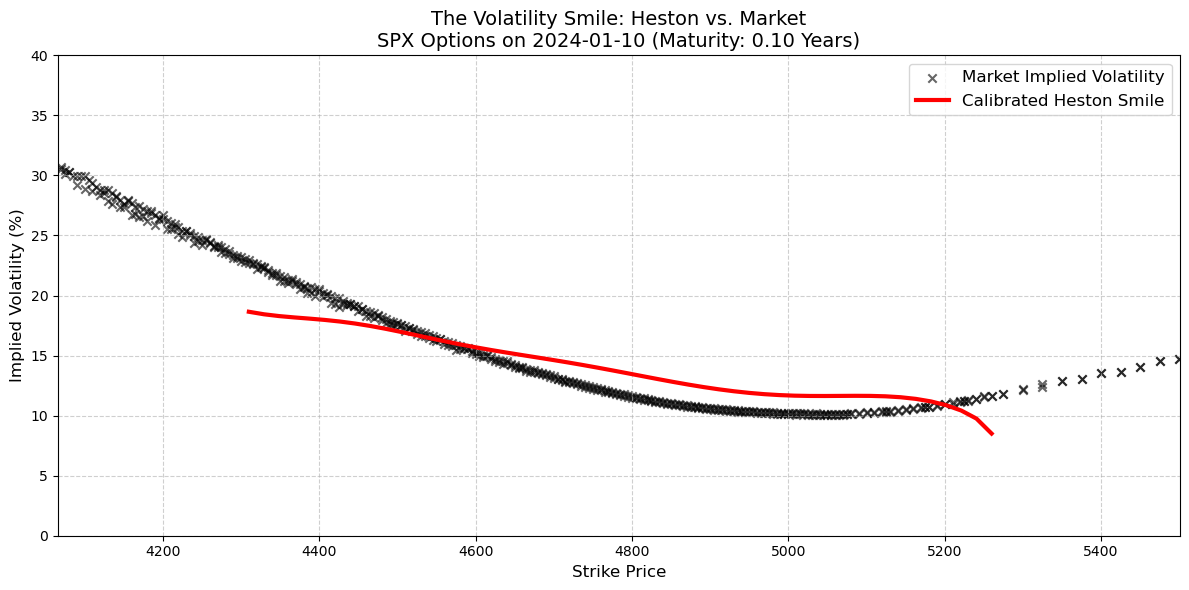

In [20]:
from scipy.optimize import brentq
import warnings

def bs_call_price(sigma, S, K, T, r, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)

def implied_volatility(target_price, S, K, T, r, q):
    intrinsic = max(S * np.exp(-q*T) - K * np.exp(-r*T), 0)
    if target_price <= intrinsic: return np.nan 

    def objective(sigma):
        return bs_call_price(sigma, S, K, T, r, q) - target_price

    try:
        return brentq(objective, 1e-4, 5.0) # Widened search bounds slightly
    except ValueError:
        return np.nan

print("Calculating Implied Volatilities... (Takes just a moment)")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    market_iv = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(market_prices, market_strikes)]
    model_iv  = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(model_prices, smooth_strikes)]

# --- THE CLEANUP FIX ---
# Filter out the NaN values so the line connects smoothly
valid_idx = ~np.isnan(model_iv)
clean_strikes = np.array(smooth_strikes)[valid_idx]
clean_iv = np.array(model_iv)[valid_idx] * 100

plt.figure(figsize=(12, 6))

# Plot only the valid Market IVs
plt.scatter(market_strikes, np.array(market_iv) * 100, color='black', label='Market Implied Volatility', marker='x', alpha=0.6)

# Plot the cleaned Heston IV line
plt.plot(clean_strikes, clean_iv, color='red', label='Calibrated Heston Smile', linewidth=3)

plt.title(f"The Volatility Smile: Heston vs. Market\nSPX Options on {TARGET_DATE} (Maturity: {T:.2f} Years)", fontsize=14)
plt.xlabel("Strike Price", fontsize=12)
plt.ylabel("Implied Volatility (%)", fontsize=12)

# Zoom in on the relevant OTM/ATM region to see the true "Smile"
plt.xlim(S0 * 0.85, S0 * 1.15) # Show from 85% to 115% of Spot Price
plt.ylim(0, 40)                # Cap IV at 40% for better visual scaling

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Merton elegantly proved that a Jump Diffusion European Call is simply an **infinite sum of Black-Scholes formulas**, weighted by the probability of $n$ jumps occurring (which follows a Poisson distribution).

$$C_{MJD} = \sum_{n=0}^{\infty} \frac{e^{-\lambda' T} (\lambda' T)^n}{n!} C_{BS}(S_0, K, T, r_n, \sigma_n)$$

Where:

- $k = \exp(\mu_J + \frac{\delta^2}{2}) - 1$ (Expected percentage jump size)
    
- $\lambda' = \lambda (1 + k)$ (Risk-neutral jump intensity)
    
- $\sigma_n^2 = \sigma^2 + \frac{n \delta^2}{T}$ (Adjusted volatility for $n$ jumps)
    
- $r_n = r - \lambda k + \frac{n \ln(1+k)}{T}$ (Adjusted risk-free rate for $n$ jumps)
    

In practice, we don't calculate to infinity. The probability of more than 20 jumps happening in a year is virtually zero, so we sum the first 20 to 50 terms.

In [13]:
import math

def merton_jump_call(S, K, T, r, q, sigma, lam, mu_j, delta, max_jumps=40):
    """
    Calculates the Merton Jump Diffusion European Call Price 
    using the analytical infinite series (truncated).
    """
    # Expected jump size (k)
    k = np.exp(mu_j + 0.5 * delta**2) - 1
    
    # Risk-neutral jump intensity
    lambda_prime = lam * (1 + k)
    
    price = 0.0
    
    # Sum the Poisson-weighted Black-Scholes prices
    for n in range(max_jumps):
        # Probability of exactly n jumps happening
        poisson_weight = np.exp(-lambda_prime * T) * ((lambda_prime * T)**n) / math.factorial(n)
        
        # Adjusted volatility for n jumps
        sigma_n = np.sqrt(sigma**2 + (n * delta**2) / T)
        
        # Adjusted risk-free rate for n jumps
        r_n = r - lam * k + (n * np.log(1 + k)) / T
        
        # Calculate BS price for this specific jump state
        bs_price_n = bs_call_price(sigma_n, S, K, T, r_n, q)
        
        # Add to total price
        price += poisson_weight * bs_price_n
        
    return price

# --- Quick Sanity Check ---
# Compare standard Black-Scholes to Merton with a 20% crash risk
bs_test = bs_call_price(sigma=0.15, S=100, K=90, T=1, r=0.05, q=0)
mjd_test = merton_jump_call(S=100, K=90, T=1, r=0.05, q=0, 
                            sigma=0.15, lam=1.0, mu_j=-0.20, delta=0.10)

print(f"Standard BS Price (OTM Put Equiv):  {bs_test:.2f}")
print(f"Merton Price (With Crash Risk):     {mjd_test:.2f}")

NameError: name 'si' is not defined